# PDAC cell embeddings

PDAC cells UMAP using zero-shot scGPT embeddings (whole and pan-cancer) and PCA, using hvgs specific in PDAC cells, colored by patients and treatmentStatus to compare heterogeneity  
PDAC cells UMAP using embeddings of fine-tuned scGPT (gene expression prediction)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from pathlib import Path
import json
from tqdm import tqdm
import warnings
import time
from einops import rearrange # for attention
import pickle
import copy

import torch
from torch import nn
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt.model import TransformerModel
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import masked_mse_loss

/bin/bash: /homes8/runzi/.conda/envs/scgpt/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
device = 'cuda'

In [3]:
params = dict(# data processing
gene_col = 'gene',
label_col = None,
data_is_raw = False,
filter_gene_by_counts = False,
input_layer_key = 'X_binned',
max_seq_len = 3001, # changed 
batch_size = 32, # training setup

# model/training only configs
domain_spec_batchnorm = 'batchnorm',
input_emb_style = "continuous",
cell_emb_style = "cls",
n_input_bins = 51,
mvc_decoder_style  = "inner product",
ecs_threshold = 0.0 ,
explicit_zero_prob = False,
use_fast_transformer = True,
fast_transformer_backend = "flash",
pre_norm = False,

n_layers_cls = 3,
nhead = 8,
embsize = 512,
d_hid = 512,
nlayers = 12,
dropout = 0.2,

lr = 1e-4,
amp  = True,
schedule_ratio=0.9,
save_eval_interval=5,
log_interval = 100,
schedule_interval = 1,

ADV = False,
MLM = True, # for masked prediction training
MVC = False,
CLS = False,
DAB = False,
CCE = False,
ECS = False,
do_sample_in_train = False,
INPUT_BATCH_LABELS = False,
num_batch_labels = None,

epochs = 15,

# model and data processing
n_bins = 51,
include_zero_gene = False, # tokenization, but affects model's setup/behavior
pad_token = '<pad>',
mask_value = -1,
pad_value = -2)

In [ ]:
data_dir = Path('/cristealab/rtan/scGPT/VDR/data')
model_dir = Path('/cristealab/rtan/scGPT/models/whole_human')
save_dir = Path('/cristealab/rtan/scGPT/VDR/save')
pancancer_dir = Path('/cristealab/rtan/scGPT/models/pan_cancer')

In [4]:
VDR = sc.read(data_dir/'VDR.h5ad')
PDAC = VDR[VDR.obs.celltype=='PDAC']
# patients with more than 1000 cells
pids = PDAC.obs.groupby(['patientID']).size().index[PDAC.obs.groupby(['patientID']).size()>1000]
PDAC = PDAC[PDAC.obs.patientID.isin(pids)]

In [10]:
# load hvgs
PDAC.var = pd.read_csv(data_dir/'PDAC_hvgs.cvs', index_col=0)

In [11]:
# filter genes by vocab
vocab_file = model_dir / "vocab.json"
vocab = GeneVocab.from_file(vocab_file)

PDAC.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in PDAC.var[params['gene_col']]]

gene_ids_in_vocab = np.array(PDAC.var["id_in_vocab"])
print(
  f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
  f"in vocabulary of size {len(vocab)}."
)
PDAC = PDAC[:, PDAC.var["id_in_vocab"] >= 0]

# keep top 3000 hvgs
hvgs_index = PDAC.var.nlargest(3000, 'variances_norm').index
PDAC = PDAC[:, hvgs_index]
PDAC.shape

match 24285/36601 genes in vocabulary of size 60697.


(21633, 3000)

In [13]:
# preprocessing: binning
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=params['filter_gene_by_counts'],  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    # result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=params['data_is_raw'],  # 4. whether to log1p the normalized data
    # result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    # hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=params['n_bins'],  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(PDAC)

scGPT - INFO - Filtering cells by counts ...


/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


scGPT - INFO - Binning data ...


In [56]:
# keep 1000 cells for each patient
def split(adata, cols, numbers, seed):
    adata_obs = adata.obs[cols]
    adata_obs.loc[:,'row'] = range(0,adata.n_obs)
    selection = adata_obs.groupby(cols).size()
    selected_indices = []
    for index in range(len(numbers)):
        df = adata_obs[(adata_obs[cols]==selection.index[index]).all(axis=1)]
        np.random.seed(123)
        selected_indices += df['row'][np.random.choice(df.shape[0], numbers[index], replace=False)].tolist()
    selected_indices.sort()

    return adata[selected_indices]
subPDAC = split(PDAC, ['patientID'], [1000]*6, 123)

/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [60]:
# convert data to model input format
def adata_to_pt(adata, gene_col='gene', layer_key='X_binned',include_zero = False, CLS = False):
    '''
    from adata to pt
    layer_key: need to consider 'X'
    '''
    all_counts = adata.layers[layer_key]
    genes = adata.var[gene_col].tolist()
    gene_ids = np.array(vocab(genes), dtype=int)
    max_seq_len = max(np.sum(adata.layers[layer_key]>0, axis = 1))+1

    tokenized_all = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=params['pad_token'],
        pad_value=params['pad_value'],
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=include_zero,
    )
    tokenized_all['values'] = torch.tensor(tokenized_all['values'], dtype = torch.float)
    if CLS:
        tokenized_all['label_ids'] = torch.from_numpy(np.array(adata.obs.label_id)).long()
    pt = {
        "gene_ids": tokenized_all['genes'],
        "values": tokenized_all['values'],
    }
    if CLS: 
        pt["labels"] = tokenized_all['label_ids'],
    return pt

# mask input values
def mask(data_pt, mask_ratio=0):
    masked_values = random_mask_value(
    data_pt["values"],
    mask_ratio=mask_ratio,
    mask_value=-1,
    pad_value=-2,
    )
    data_pt.update({'masked_values':masked_values})
    return data_pt

In [ ]:
# prepare pt
train_data, test_data = train_test_split(subPDAC, test_size= 0.2, stratify=subPDAC.obs.patientID, shuffle=True, random_state=123)
train_data, valid_data = train_test_split(train_data, test_size= 0.25, stratify=train_data.obs.patientID, shuffle=True, random_state=123)

In [112]:
train_pt = adata_to_pt(train_data)
train_pt = mask(train_pt, mask_ratio = 0.4)
valid_pt = adata_to_pt(valid_data)
valid_pt = mask(valid_pt, mask_ratio = 0.4)
test_pt = adata_to_pt(test_data)
test_pt = mask(test_pt, mask_ratio = 0.4)

/tmp/ipykernel_3621405/3624361991.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_all['values'] = torch.tensor(tokenized_all['values'], dtype = torch.float)


In [92]:
# dataset
class SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}
    

# data_loader
def prepare_dataloader(
    data_pt,
    batch_size: int,
    shuffle: bool = True,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

## zero-shot and pca umap plots

scGPT - INFO - match 3000/3000 genes in vocabulary of size 60697.


/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/scgpt/tasks/cell_emb.py:209: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [
Embedding cells: 100%|██████████| 339/339 [00:48<00:00,  7.06it/s]
/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


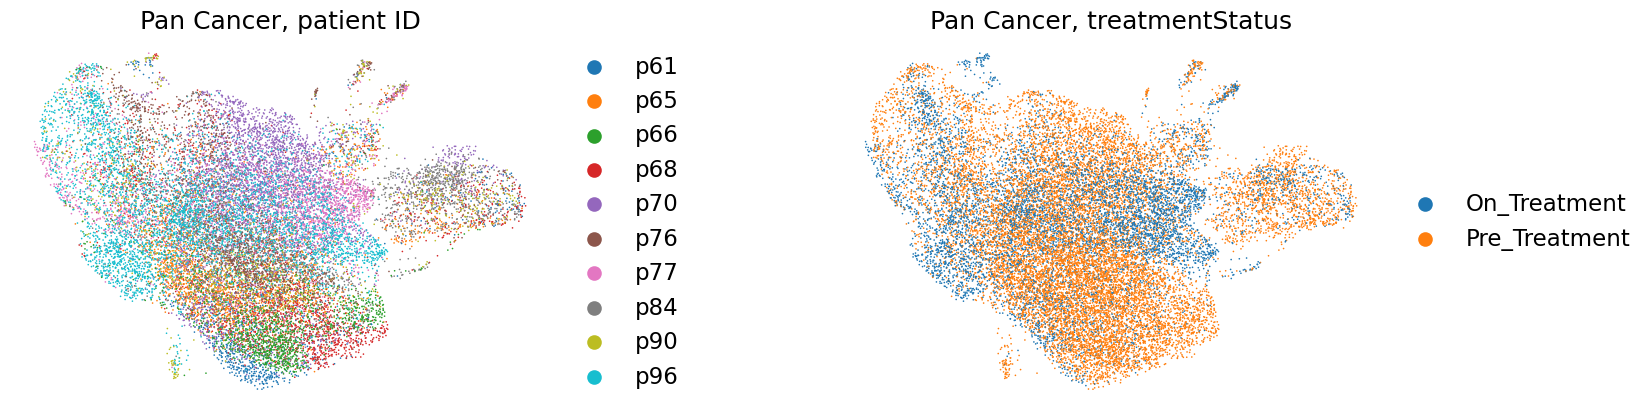

In [30]:
# use pancancer model to show cluster
embed_adata = scg.tasks.embed_data(
    PDAC,
    pancancer_dir,
    gene_col=params['gene_col'],
    batch_size=64,
)

sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
# save UMAP embeddings
embed_adata.obsm['pancancer_umap'] = embed_adata.obsm['X_umap']

sc.pl.umap(embed_adata, 
           color=['patientID', 'treatmentStatus'], 
           frameon=False, 
           wspace=0.4, 
           title=[ "Pan Cancer, patient ID", "Pan Cancer, treatmentStatus"])

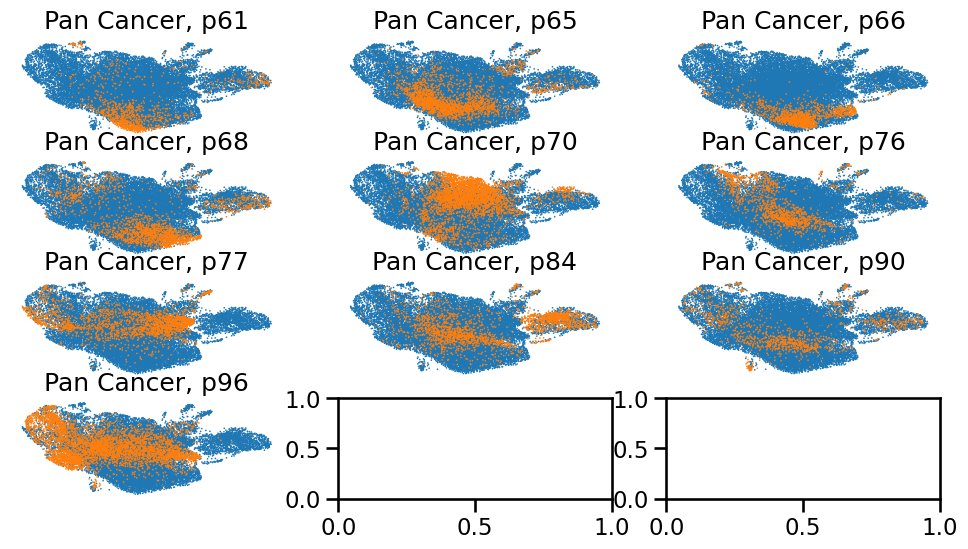

In [32]:
# show cells of each patient
# reorder cells to keep shown is above others
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,6))
axes = axes.flatten()

for i, pid in enumerate(pids):
    embed_adata.obs['highlight'] = [pid if v==pid else 'other' for v in embed_adata.obs.patientID]
    '''
    Reorder the values so that selected values not covered
    '''
    embed_adata.obs['plot_order'] = embed_adata.obs['patientID'] == pid
    embed_adata = embed_adata[embed_adata.obs.sort_values(by='plot_order').index]
    sc.pl.umap(embed_adata, 
           color=['highlight'], 
           frameon=False, 
           wspace=0.4, 
           title=[f"Pan Cancer, {pid}"],
           legend_loc=None,
           ax = axes[i],
            show = False)
plt.show()

scGPT - INFO - match 3000/3000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 339/339 [00:52<00:00,  6.49it/s]
/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


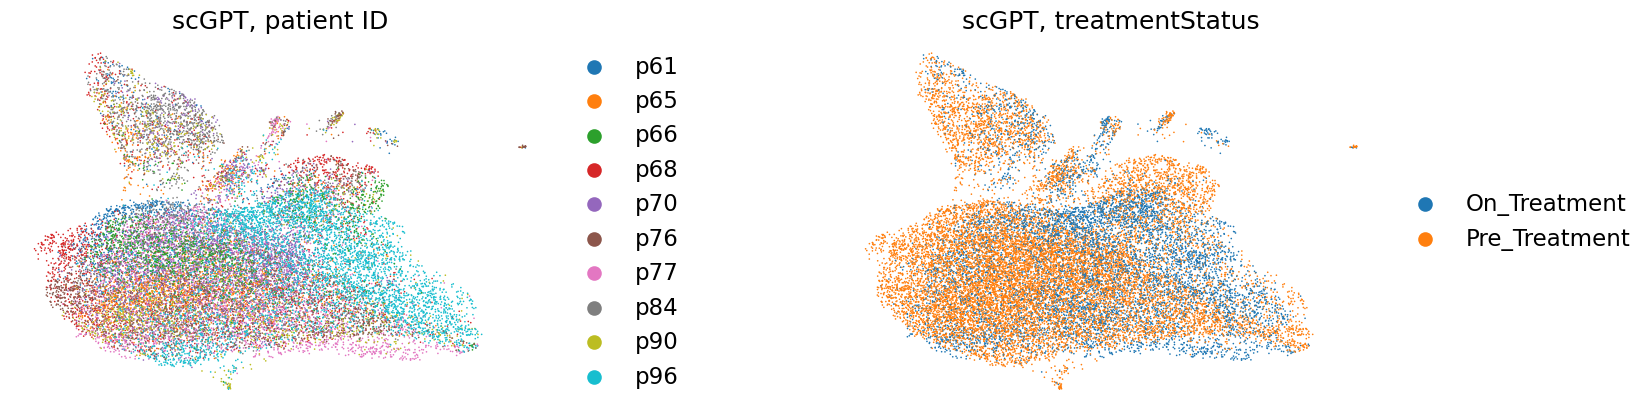

In [34]:
# use whole model to show PDAC by patients
embed_whole = scg.tasks.embed_data(
    PDAC,
    model_dir,
    gene_col=params['gene_col'],
    batch_size=64,
)
sc.pp.neighbors(embed_whole, use_rep="X_scGPT")
sc.tl.umap(embed_whole)
sc.pl.umap(embed_whole, 
           color=['patientID', 'treatmentStatus'], 
           frameon=False, 
           wspace=0.4, 
           title=[ "scGPT, patient ID", "scGPT, treatmentStatus"])

/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


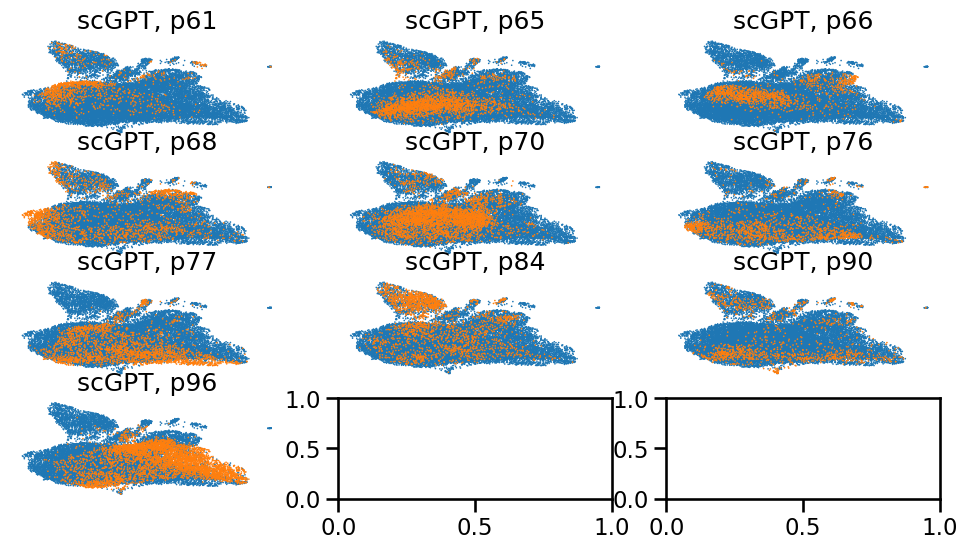

In [35]:
# show cells of each patient
# reorder cells to keep shown is above others
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,6))
axes = axes.flatten()

for i, pid in enumerate(pids):
    embed_whole.obs['highlight'] = [pid if v==pid else 'other' for v in embed_whole.obs.patientID]
    '''
    Reorder the values so that selected values not covered
    '''
    embed_whole.obs['plot_order'] = embed_whole.obs['patientID'] == pid
    embed_whole = embed_whole[embed_whole.obs.sort_values(by='plot_order').index]
    sc.pl.umap(embed_whole, 
           color=['highlight'], 
           frameon=False, 
           wspace=0.4, 
           title=[f"scGPT, {pid}"],
           legend_loc=None,
           ax = axes[i],
            show = False)
plt.show()

/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


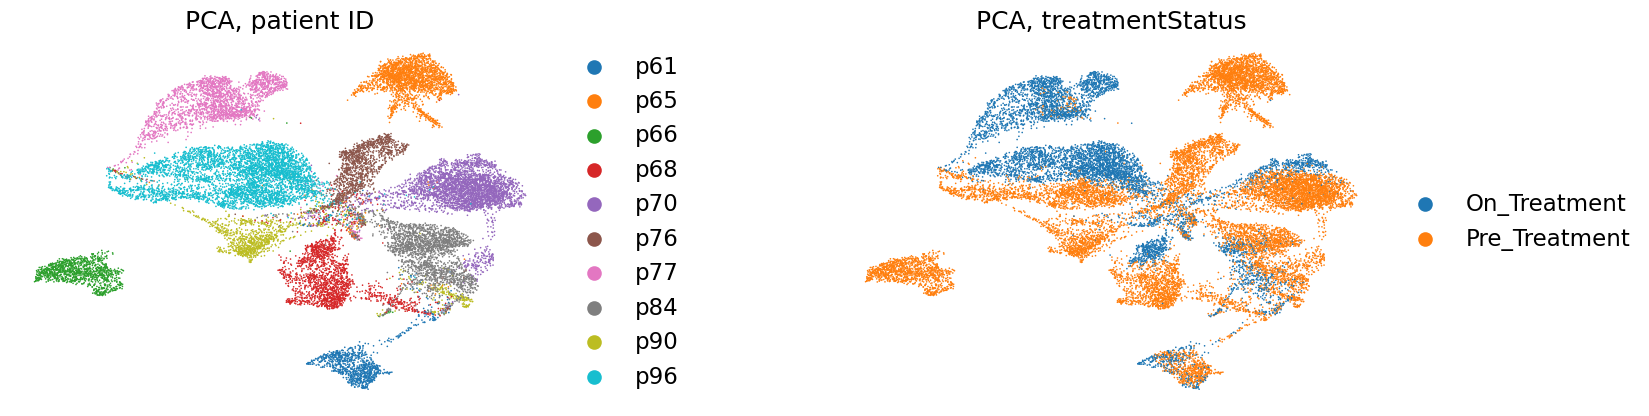

In [38]:
# pca 
# used the embed_adata which was used for pan cancer model embeddings
sc.tl.pca(embed_adata)
sc.pp.neighbors(embed_adata, n_pcs=30, use_rep='X_pca')
sc.tl.umap(embed_adata)

embed_adata.obsm['pca_umap'] = embed_adata.obsm['X_umap']
sc.pl.umap(embed_adata, 
           color=['patientID', 'treatmentStatus'], 
           frameon=False, 
           wspace=0.4, 
           title=["PCA, patient ID", "PCA, treatmentStatus"])

/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


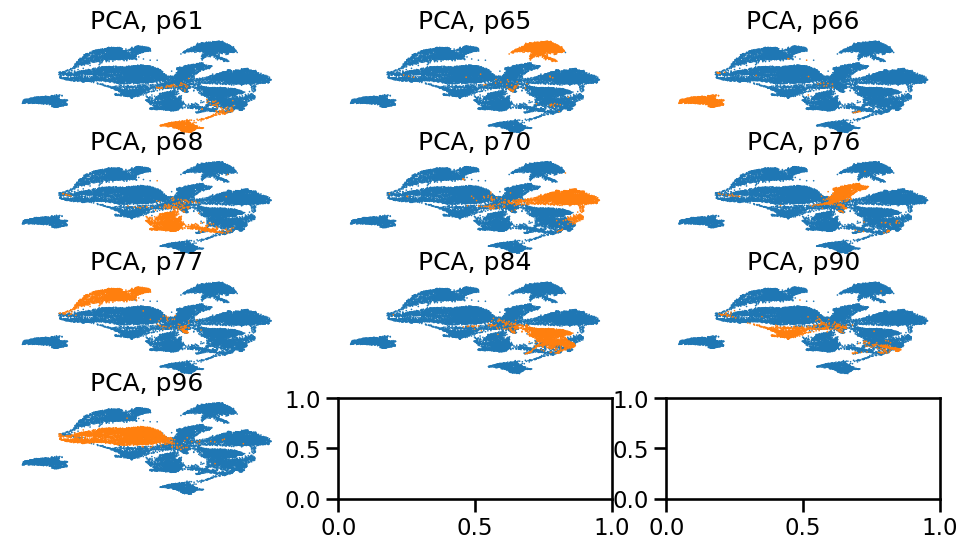

In [39]:
# by single patients
# reorder cells to keep shown is above others
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,6))
axes = axes.flatten()

for i, pid in enumerate(pids):
    embed_adata.obs['highlight'] = [pid if v==pid else 'other' for v in embed_adata.obs.patientID]
    '''
    Reorder the values so that selected values not covered
    '''
    embed_adata.obs['plot_order'] = embed_adata.obs['patientID'] == pid
    embed_adata = embed_adata[embed_adata.obs.sort_values(by='plot_order').index]
    sc.pl.umap(embed_adata, 
           color=['highlight'], 
           frameon=False, 
           wspace=0.4, 
           title=[f"PCA, {pid}"],
           legend_loc=None,
           ax = axes[i],
            show = False)
plt.show()

In [42]:
# show pre-on pairs
PDAC.obs.groupby(['treatmentStatus','patientID']).size().unstack()

patientID,p61,p65,p66,p68,p70,p76,p77,p84,p90,p96
treatmentStatus,,,,,,,,,,
On_Treatment,378,0,0,491,622,0,2172,604,105,2808
Pre_Treatment,714,2263,1243,1438,2889,1388,80,1632,1142,1664


/tmp/ipykernel_3621405/1107521753.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  patient.obs['highlight'] = ['Pre_Treatment' if v=='Pre_Treatment' else 'On_Treatment' for v in patient.obs.treatmentStatus]


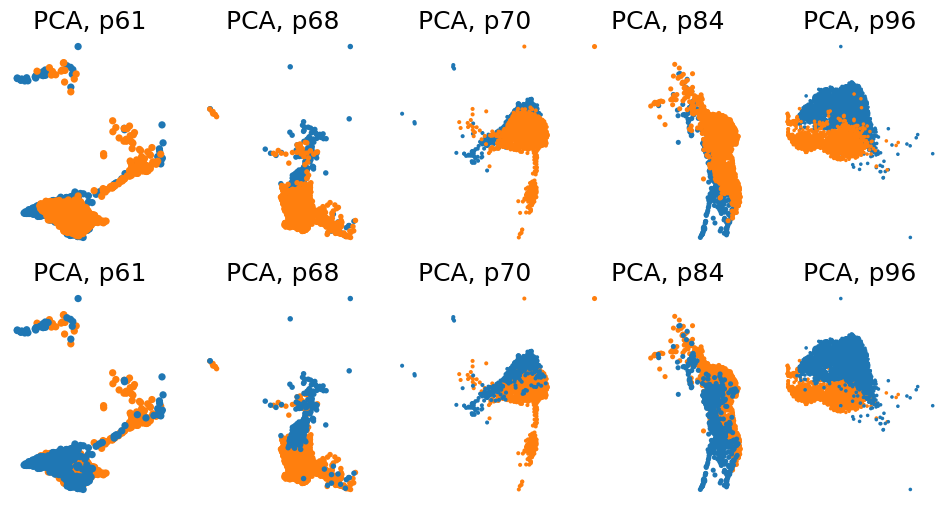

In [46]:
# pca, by treatment status 
pair_pids = ['p61', 'p68', 'p70', 'p84', 'p96']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
axes = axes.flatten()

for i, pid in enumerate(pair_pids):
    patient = embed_adata[embed_adata.obs.patientID==pid]
    patient.obs['highlight'] = ['Pre_Treatment' if v=='Pre_Treatment' else 'On_Treatment' for v in patient.obs.treatmentStatus]
    '''
    Reorder the values so that selected values not covered
    '''
    patient.obs['plot_order'] = patient.obs['treatmentStatus'] == 'Pre_Treatment'
    patient = patient[patient.obs.sort_values(by='plot_order').index]
    sc.pl.umap(patient, 
           color=['highlight'], 
           frameon=False, 
           wspace=0.4, 
           title=[f"PCA, {pid}"],
           legend_loc=None,
           ax = axes[i],
            show = False)
    
    patient.obs['highlight'] = ['On_Treatment' if v=='On_Treatment' else 'Pre_Treatment' for v in patient.obs.treatmentStatus]
    '''
    Reorder the values so that selected values not covered
    '''
    patient.obs['plot_order'] = patient.obs['treatmentStatus'] == 'On_Treatment'
    patient = patient[patient.obs.sort_values(by='plot_order').index]
    sc.pl.umap(patient, 
           color=['highlight'], 
           frameon=False, 
           wspace=0.4, 
           title=[f"PCA, {pid}"],
           legend_loc=None,
           ax = axes[i+5],
            show = False)
plt.show()

/tmp/ipykernel_3621405/2002136883.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  patient.obs['highlight'] = ['Pre_Treatment' if v=='Pre_Treatment' else 'On_Treatment' for v in patient.obs.treatmentStatus]


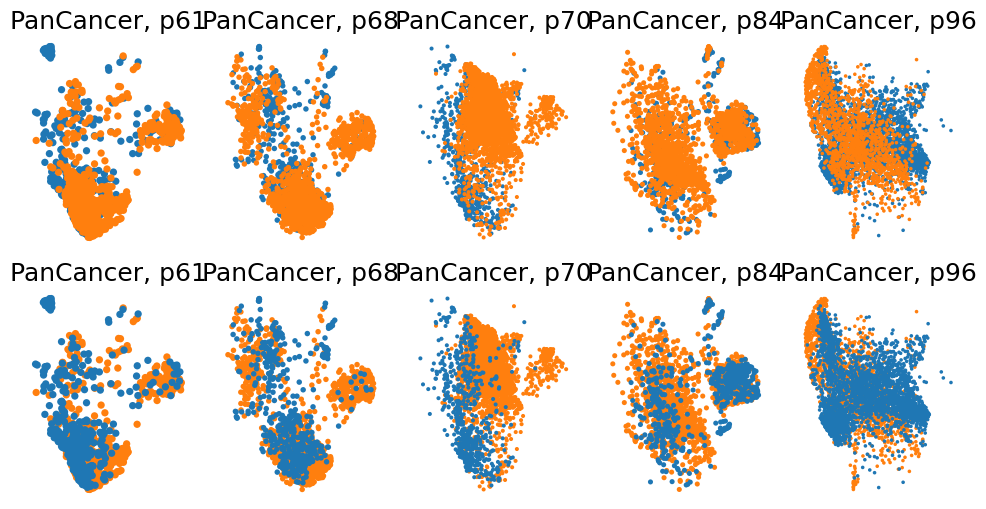

In [50]:
# pan cancer embed, by treatment status
# resume embeddings
embed_adata.obsm['X_umap'] = embed_adata.obsm['pancancer_umap']
pair_pids = ['p61', 'p68', 'p70', 'p84', 'p96']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
axes = axes.flatten()


for i, pid in enumerate(pair_pids):
    patient = embed_adata[embed_adata.obs.patientID==pid]
    patient.obs['highlight'] = ['Pre_Treatment' if v=='Pre_Treatment' else 'On_Treatment' for v in patient.obs.treatmentStatus]
    '''
    Reorder the values so that selected values not covered
    '''
    patient.obs['plot_order'] = patient.obs['treatmentStatus'] == 'Pre_Treatment'
    patient = patient[patient.obs.sort_values(by='plot_order').index]
    sc.pl.umap(patient, 
           color=['highlight'], 
           frameon=False, 
           wspace=0.4, 
           title=[f"PanCancer, {pid}"],
           legend_loc=None,
           ax = axes[i],
            show = False)
    
    patient.obs['highlight'] = ['On_Treatment' if v=='On_Treatment' else 'Pre_Treatment' for v in patient.obs.treatmentStatus]
    '''
    Reorder the values so that selected values not covered
    '''
    patient.obs['plot_order'] = patient.obs['treatmentStatus'] == 'On_Treatment'
    patient = patient[patient.obs.sort_values(by='plot_order').index]
    sc.pl.umap(patient, 
           color=['highlight'], 
           frameon=False, 
           wspace=0.4, 
           title=[f"PanCancer, {pid}"],
           legend_loc=None,
           ax = axes[i+5],
            show = False)
plt.show()

## embeddings of fine-tuned model

In [ ]:
# load fine tuned model
with open(save_dir/'GEP_PDAC.pickle', 'rb') as handle:
    finetuned = pickle.load(handle)

In [131]:
def layer_embed(model, all_gene_ids, all_values, before_transformer = False, src_key_padding_mask = None, layers = range(12), batch_size = 64, bn = False):
    model.eval()
    model.to(device)
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
        M = all_gene_ids.size(1) # seq length in data
        N = all_gene_ids.size(0) # number of cells
    # device = next(model.parameters()).device
        if before_transformer: before_transformer_output = np.zeros(( N, 512), dtype=np.float32) 
        output = np.zeros((len(layers), N, 512), dtype=np.float32)
        for i in tqdm(range(0, N, batch_size)):
            batch_size = all_gene_ids[i : i + batch_size].size(0)
            # Replicate the operations in model forward pass
            src_embs = model.encoder(all_gene_ids[i : i + batch_size].to(device))
            val_embs = model.value_encoder(all_values[i : i + batch_size].to(device))
            total_embs = src_embs + val_embs
            if bn: total_embs = model.bn(total_embs.permute(0, 2, 1)).permute(0, 2, 1)
            if before_transformer: before_transformer_output[ i : i + batch_size] = total_embs[:,0,:].clone().detach().cpu().numpy()
            end_layer = max(layers)+1
            for n, layer in enumerate(model.transformer_encoder.layers[:end_layer]):
                total_embs = layer(total_embs, src_key_padding_mask=src_key_padding_mask[i : i + batch_size].to(device))
                if n in layers:
                    output[layers.index(n), i : i + batch_size] = total_embs[:,0,:].clone().detach().cpu().numpy()
    return [output, before_transformer_output] if before_transformer else output

In [144]:
# fine tuned model embeddings for test_data
finetuned_embed = layer_embed(finetuned, test_pt['gene_ids'],test_pt['values'], src_key_padding_mask=test_pt['values'].eq(params['pad_value']), layers=[11], bn=True)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:01<00:00, 18.83it/s]


/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


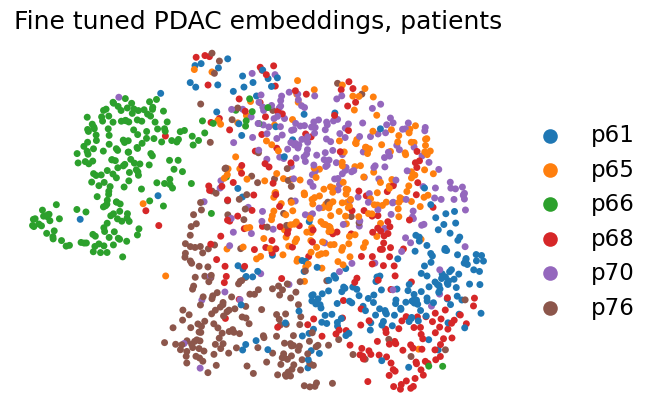

In [145]:
test_data.obsm['fine_tuned'] = finetuned_embed[0]
sc.pp.neighbors(test_data,n_pcs = 512, use_rep='fine_tuned') # save results in obsp
sc.tl.umap(test_data)
sc.pl.umap(test_data, 
           color=['patientID'], 
           frameon=False, 
           wspace=0.4, 
           title=["Fine tuned PDAC embeddings, patients"])

In [146]:
# fine tuned model embeddings for train data
finetuned_train_embed = layer_embed(finetuned, train_pt['gene_ids'],train_pt['values'], src_key_padding_mask=train_pt['values'].eq(params['pad_value']), layers=[11], bn=True)

100%|██████████| 57/57 [00:03<00:00, 16.27it/s]


/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


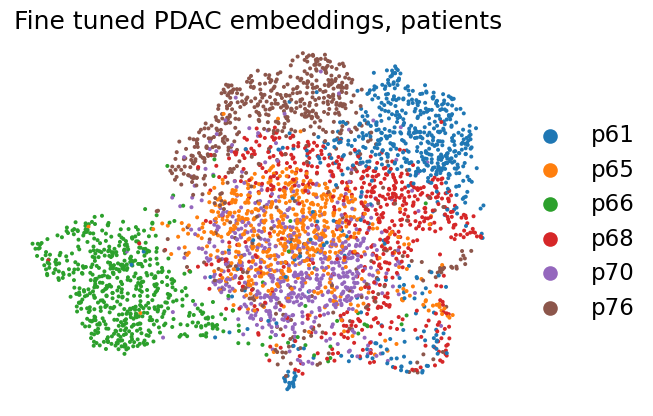

In [147]:
train_data.obsm['fine_tuned'] = finetuned_train_embed[0]
sc.pp.neighbors(train_data,n_pcs = 512, use_rep='fine_tuned') # save results in obsp
sc.tl.umap(train_data)
sc.pl.umap(train_data, 
           color=['patientID'], 
           frameon=False, 
           wspace=0.4, 
           title=["Fine tuned PDAC embeddings, patients"])